<a href="https://colab.research.google.com/github/ygmurkara/DI501/blob/main/DI_501_Lab_3_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DI 501: Classification and Model Tuning

In this portion of the lab we will discuss classification, how to tune hyperparameters of our models for best performance, and more.

We will train models to find rules regarding attributes, which will be useful when new data comes along so we can classify them according to the rules. (We will also look back at our data to see how well we did.)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Iris plants dataset

<img src="https://images.datacamp.com/image/upload/v1543279550/flower_zbhqb3.png" alt="image of different iris" width="700"/>

This is one of the most popular toy datasets for machine learning. You might have heard of it. We will discover it's features and distributions in a bit.

In [ ]:
iris = pd.read_csv("iris.data", names=['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'variety'])

iris.head()

,sepal-length,sepal-width,petal-length,petal-width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Pairplot

Let's utilize seaborn to create a pairplot with pairwise scatter plots and density plots.

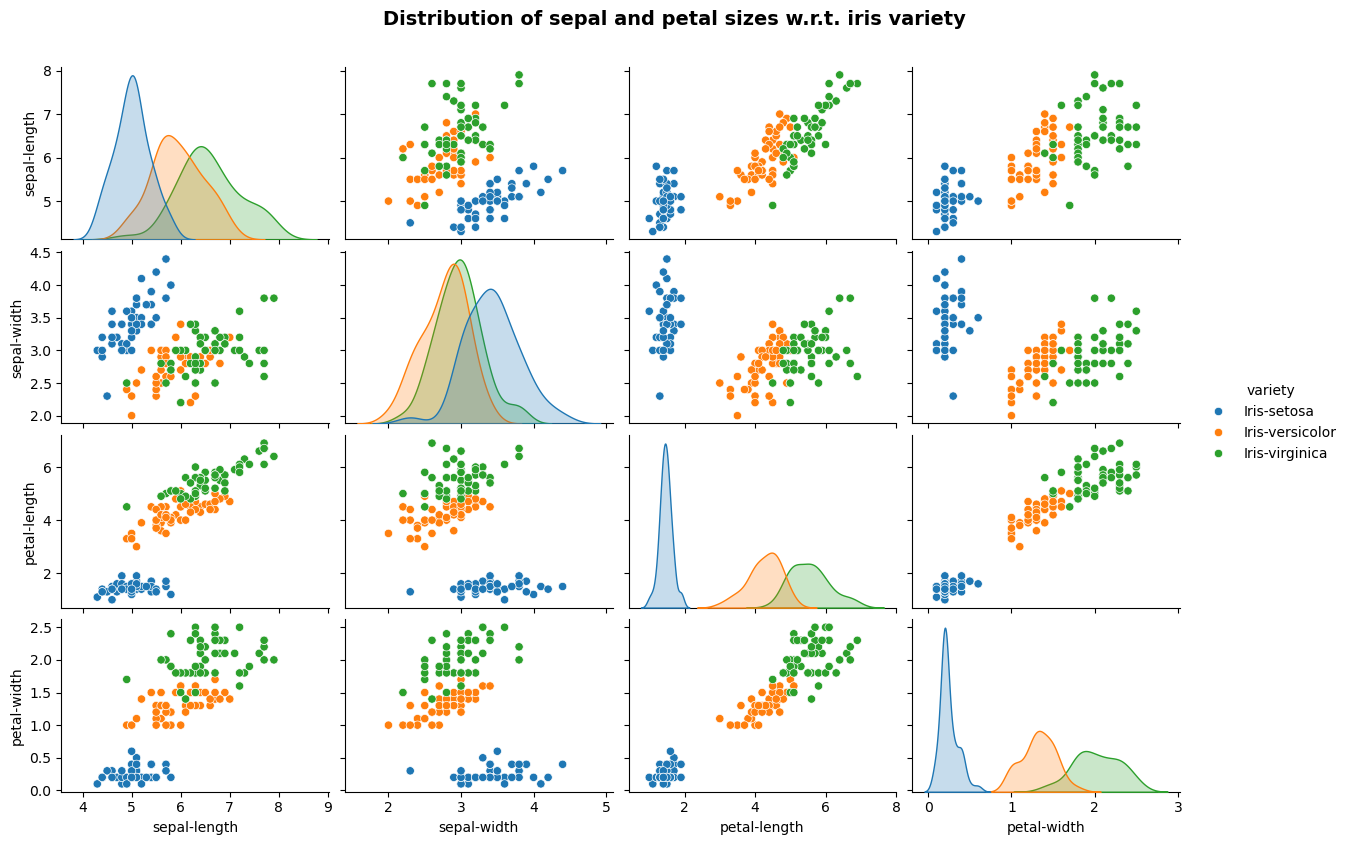

In [ ]:
sns.pairplot(iris, hue='variety', height=2, aspect=1.5)

plt.suptitle('Distribution of sepal and petal sizes w.r.t. iris variety',
             y=1.05, fontsize=14, fontweight='semibold');

We can see how iris-setosa is much further from the other two varieties in any combination. Versicolor and virginica also appears to be seperable but there are tiny occlusions. Of course in a four dimensional space the problem could be easier to solve.

## Label Encoding

Most machine learning models in scikit-learn require the target variable (y) to be numeric.
Since our labels (like "Iris-versicolor" or "Iris-setosa") are strings, we use LabelEncoder to convert them into integer values so models can process them correctly and efficiently.

`LabelEncoder()` in sklearn is usually used to transform nominal target classes to integers. As you can guess, the order won't be informative. It has three main methods we will use:

* `fit_transform`: this will fit a rule to encode our labels, and apply that rule to the same data and returns them

    (we can also use `fit` or `transform` methods separately if needed)

* `inverse_transform`: given encoded labels, this method will return original labels in our dataset


In [ ]:
le = preprocessing.LabelEncoder()

iris.variety = le.fit_transform(iris.variety)

le.inverse_transform([0,1,2,0])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa'],
      dtype=object)

In [ ]:
print(le.classes_)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


## Splitting into test and training

We will also set aside a random 20% of our data to be the test set here.

Setting `random_state` implies while this is random in nature, repeated execution of the cell below will give the same results.

Also the `stratify` keyword argument ensures each split has the same distribution of labels as the original dataset. While our dataset has fairly balanced label distribution, this will be important for other cases (whether imbalanced, or low number of samples overall).

In [ ]:
X, y = iris.iloc[:,:4], iris.variety

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify=y)

## K-Nearest Neighbors

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.
 - It is a lazy learning algorithm since it doesn't have a specialized training phase.</li>
 - It uses all of the data for training while classifying a new data point or instance.</li>
- KNN is a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data.<br><br>

When making a prediction, K-Nearest Neighbors (KNN) identifies the ‘k’ training samples that are closest to the new data point, based on a distance metric such as Euclidean distance.
The predicted class is then determined by a majority vote among these 'k' nearest neighbors — whichever class appears most frequently among them is assigned to the new point.

The performance of KNN can be heavily influenced by the choice of 'k' and the distance metric.</li>


We will first define the classifier with `n_neighbors` set to 1. We will later show what happens when this value is adjusted.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

Training accuracy: 1.00
Test accuracy: 	 0.93


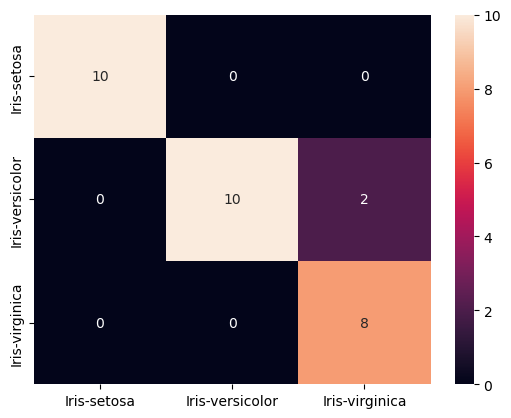

In [ ]:
print(f'Training accuracy: {metrics.accuracy_score(y_train, train_pred):.2f}')
print(f'Test accuracy: \t {metrics.accuracy_score(y_test, test_pred):.2f}')

# accuracy_score calculates the ratio of correct predictions to the total number of predictions

sns.heatmap(metrics.confusion_matrix(test_pred, y_test), annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_);

Here we can see how the model performs perfectly in the training set, but couldn't distinguish between virginica and versicolor flowers in the test set it has not seen before.

Each row in the matrix represents the true class, and each column represents the predicted class. Diagonal values show correct predictions.

**Rows = Actual labels**  
**Columns = Predicted labels**

|                  | Pred: Setosa | Pred: Versicolor | Pred: Virginica |
|------------------|--------------|------------------|-----------------|
| **Actual: Setosa**     | 10           | 0                | 0               |
| **Actual: Versicolor** | 0            | 10               | 2               |
| **Actual: Virginica**  | 0            | 0                | 8               |

- The model perfectly classified all Iris-setosa (10/10 correct).
- Iris-virginica also performed well with 8/8 correct predictions.

- For Iris-versicolor, 2 samples were misclassified as Iris-virginica.
- This suggests that some Versicolor and Virginica examples are close in feature space and possibly overlap.

## Hyperparameter tuning

Before using scikit-learn functions, let's see how this works by hand.

Hyperparameter tuning means different parameter options will be tried, scored, and the decision with the best score will be taken as the "best model". To measure performance accurately, we need a third split called a "validation set". If we were to use the test set, we would just overfit the test set. Setting aside a validation set helps prevent this a bit, in certain scenarios.

Here we will split the test set further into a validation and a new test set.

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1337, stratify=y_test)

Let's pick all odd numbers from 1 to 25 (we usually use odd values to avoid ties in voting). This will be our parameter grid. Then we will loop over each k, make a new model, train it, calculate accuracy on the validation set and save it in a list.

In [ ]:
# Define a range of odd k values from 1 to 25 (to avoid tie votes in KNN)
candidate_k = range(1, 27, 2)

# Initialize an empty list to store accuracy scores for each k
acc = []

# Loop over each k value
for k in candidate_k:
    # Create a KNN classifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the model on the training data
    knn.fit(X_train, y_train)

    # Predict labels for the validation set
    val_pred = knn.predict(X_val)

    # Calculate accuracy score on the validation set
    val_acc = metrics.accuracy_score(val_pred, y_val)

    # Store the accuracy score
    acc.append(val_acc)


We can then plot validation accuracy for different k values.

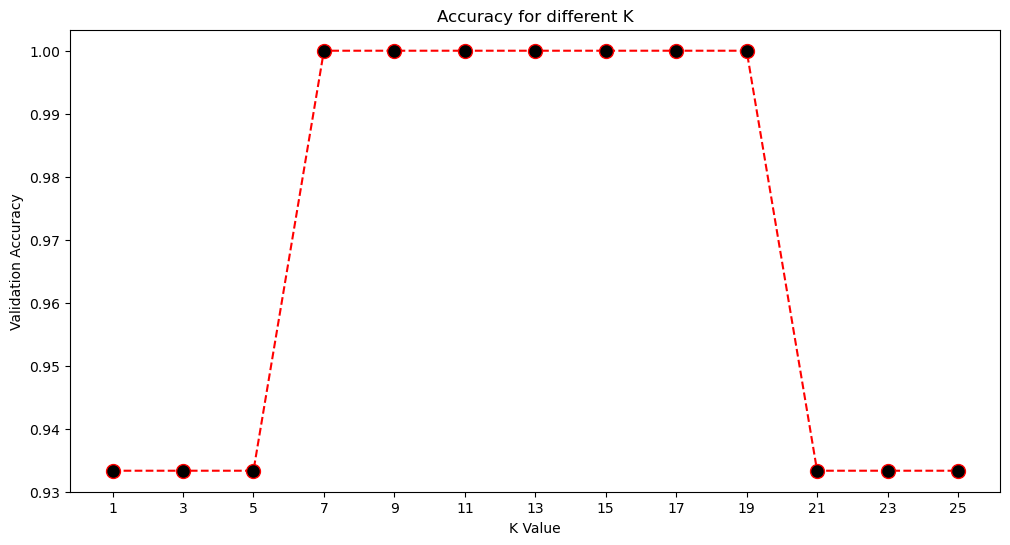

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(candidate_k, acc, color='r', linestyle='dashed', marker='o',
         markerfacecolor='k', markersize=10)
plt.title('Accuracy for different K')
plt.xticks(candidate_k)
plt.xlabel('K Value')
plt.ylabel('Validation Accuracy');

We can see at least on the validation set, k=1-5 is beaten by k values greater than 7 up to 19. Let's pick k=7 and test it on the test set.

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=7)

best_knn.fit(X_train, y_train)

train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

Training accuracy: 0.97
Test accuracy: 	 0.93


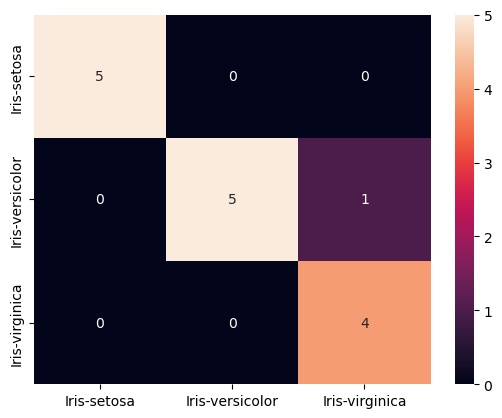

In [ ]:
print(f'Training accuracy: {metrics.accuracy_score(y_train, train_pred):.2f}')
print(f'Test accuracy: \t {metrics.accuracy_score(y_test, test_pred):.2f}')

sns.heatmap(metrics.confusion_matrix(test_pred, y_test), annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_);

Our model performance didn't change, but this is also due to our task being relatively simple, and adjusting K does not change model performance all that much. But this might also be due to having a fixed validation set. If it does not capture the training set distribution very well, we might get mixed signals. Cross validation can help us here.

## Cross-validation and grid-search

Using scikit-learn functions can make this process very streamlined. But it is important to understand what is happening in the background, and to be able to intervene when needs change.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

* Here we can go beyond optimizing one parameter and supply a grid in the form of a dictionary.

* We will run a grid search on the parameter grid, meaning every combination will be tried. (*If there are many combinations, randomized search can be preferred.*)

* Notice `scoring` is set to accuracy for this task. It can be changed to many [keywords](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and also a custom function.

* `cv` indicates how many folds we want there to be. In our example, we are using 150 total samples.

 We first split the data:

 - 80% for training → 120 samples
 - 20% for testing

When we apply cv=5 during grid search on the 120 training samples, the data is divided into 5 equal folds, each with 24 samples.

For each fold:

* 96 samples are used to train the model
* 24 samples are used to validate it
* This process repeats 5 times, so that every fold serves once as a validation set.


* The score will be calculated for each fold and their average will be used to determine the best overall model.

* Finally `verbose` just allows us to look at each step, score, and the time taken. It will be useful to track the search algorithm if the model is more complex and thus takes time.


In [ ]:
# Define a grid of hyperparameters to search over
knn_grid = {
    'n_neighbors': candidate_k,               # List of K values (number of neighbors) to try
    'weights': ['uniform', 'distance'],       # 'uniform' = equal weight, 'distance' = closer neighbors matter more
    'p': [1, 2, 3]                             # Distance metrics: 1 = Manhattan, 2 = Euclidean, 3 = higher-order
}

# Initialize the KNN classifier (will be tuned by GridSearch)
knn = KNeighborsClassifier()

# Perform grid search with 5-fold cross-validation using accuracy as the scoring metric
knn_grid_search = GridSearchCV(
    knn,
    param_grid=knn_grid,     # the hyperparameter grid to search
    scoring='accuracy',      # evaluation metric
    cv=5,                    # 5-fold cross-validation
    verbose=3                # print detailed progress
)


In [ ]:
knn_grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits
[CV 1/5] END n_neighbors=1, p=1, weights=uniform;, score=0.875 total time=   0.0s
[CV 2/5] END n_neighbors=1, p=1, weights=uniform;, score=0.958 total time=   0.0s
[CV 3/5] END n_neighbors=1, p=1, weights=uniform;, score=0.958 total time=   0.0s
[CV 4/5] END n_neighbors=1, p=1, weights=uniform;, score=0.917 total time=   0.0s
[CV 5/5] END n_neighbors=1, p=1, weights=uniform;, score=1.000 total time=   0.0s
[CV 1/5] END n_neighbors=1, p=1, weights=distance;, score=0.875 total time=   0.0s
[CV 2/5] END n_neighbors=1, p=1, weights=distance;, score=0.958 total time=   0.0s
[CV 3/5] END n_neighbors=1, p=1, weights=distance;, score=0.958 total time=   0.0s
[CV 4/5] END n_neighbors=1, p=1, weights=distance;, score=0.917 total time=   0.0s
[CV 5/5] END n_neighbors=1, p=1, weights=distance;, score=1.000 total time=   0.0s
[CV 1/5] END n_neighbors=1, p=2, weights=uniform;, score=0.917 total time=   0.0s
[CV 2/5] END n_neighbors=1, p=2

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 27, 2), 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

Best parameters found can be accessed afterwards by the `best_params_` attribute, as well as the self-explanatory `best_score_`:

In [ ]:
print(f'With best parameters: {knn_grid_search.best_params_}\nan accuracy score of {knn_grid_search.best_score_:.2%} was reached.')

With best parameters: {'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
an accuracy score of 97.50% was reached.


The best model is also saved, so we can use it to generate predictions and evaluate our best model.

In [ ]:
best_knn = knn_grid_search.best_estimator_

train_pred = best_knn.predict(X_train)
test_pred = best_knn.predict(X_test)

Training accuracy: 0.97
Test accuracy: 	 0.93


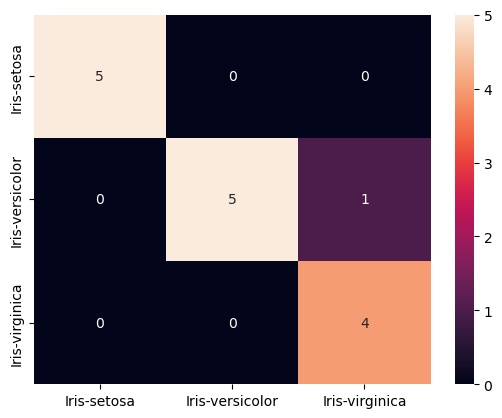

In [ ]:
print(f'Training accuracy: {metrics.accuracy_score(y_train, train_pred):.2f}')
print(f'Test accuracy: \t {metrics.accuracy_score(y_test, test_pred):.2f}')

sns.heatmap(metrics.confusion_matrix(test_pred, y_test), annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_);

We can see our problem didn't evolve very far from our hand-made optimization. It seems we have reached the limit of KNN, and other algorithms could be tried. We will talk about them in the next part involving another dataset.